# **Time Series ML with LSTM with Keras (TF 2.0)**

This notebook is for me practicing time series ML with LSTM and based on **Multivariate Time Series Forecasting with LSTMs in Keras** by **Dr Jason Brownlee** . The great original work is here https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


The raw data file is a Beijing air quality dataset. the dataset was pre-processed a bit to be used in this work.

The input dataset has 13 features. a **many-to-many** LSTM model is used with multiple timesteps and features input, one timestep and selected features ouput.



## modification from the original work in v1

1.   One-hot encoding is implemented for 'wind direction'.
2.   'hours' and 'day-of-year' features are added.
3.   Providing more than 1 hour of input time steps.
4.   make output features selectable, automatically drop others

## modification from v1

1.   implement multiple output timestep at data prep
2.   use many-to-many LSTM model with 2 stages
3.   simplify inverse scaling for output features
4.   change codes around for 'values' assignment to avoid re-run issue 
5.   more plots

## conditions


*   input timesteps = 24 hours
*   pred timestep = 4 hour
*   input features: all
*   output features: pm2.5, temp, rain, hour
*   train data duration: 4 years
*   test data duration: 1 year
*   neurons = 50
*   return_sequence = **false**  for 1st stage, **Ture** for output






























In [0]:
!pip install --upgrade -q tensorflow

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)


#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import LearningRateScheduler

2.0.0


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')


## **Processing data**


In [0]:
# load dataset

gdrive="/content/gdrive/My Drive/Colab Notebooks/time series/data/"

dataset = pd.read_csv(gdrive + 'beijing_pm25_dp.csv', header=0, index_col=0)

In [49]:
dataset.head(10)

,pm2.5,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv,doy,hour
date,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,2,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,2,1
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,2,2
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,2,3
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,2,4
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,7.14,3,0,0,0,1,0,2,5
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,8.93,4,0,0,0,1,0,2,6
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,10.72,0,0,0,0,1,0,2,7
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,12.51,0,0,0,0,1,0,2,8


In [50]:
dataset.dtypes

pm2.5         float64
dew             int64
temp          float64
press         float64
wnd_spd       float64
snow            int64
rain            int64
wnd_dir_NE      int64
wnd_dir_NW      int64
wnd_dir_SE      int64
wnd_dir_cv      int64
doy             int64
hour            int64
dtype: object

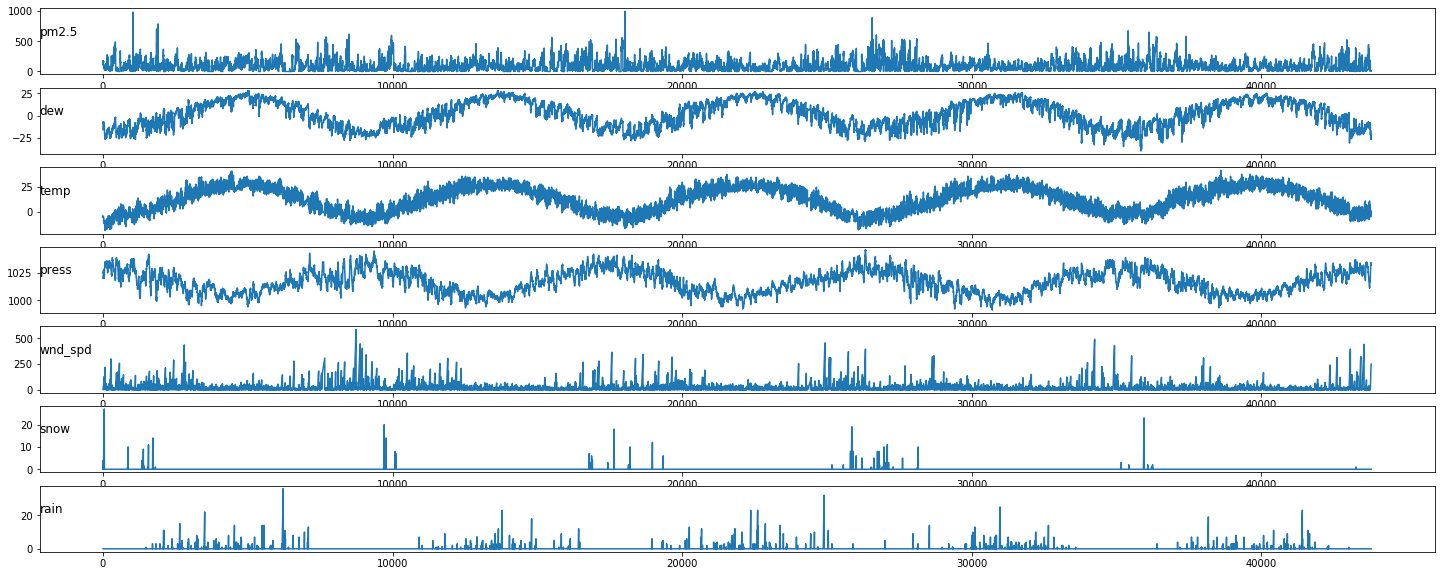

In [51]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(25,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(dataset.values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='left')
	i += 1
plt.show()

In [0]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [0]:
def drop_out_col(n_in, n_out, n_in_features, out_keep):
  columns=np.arange(n_in_features)
  columns=np.setdiff1d(columns, out_keep)

  drop = np.array([])
  for i in range(n_out):
    drop = np.append(drop, n_in_features*i+columns)
  
  drop+= n_in*n_in_features

  return np.int_(drop)


def name_to_col(dataset, name):
  return np.sort([dataset.columns.get_loc(c) for c in name if c in dataset])

In [89]:
# convert data to supervised learning format to feed LSTM 
# example: 
# input = 3 step, output = 1 time step, 3 features, pm2.5, rain, snow [0,5,6]
# each series has 13 features, input data has 3*13=39 column. output has 3, which are 39+[0,5,6]=[39,44,45]
# columns to drop from the output of series_to_supervised are [40,41,42,43,46,47,48,49,50,51]



# specify the number of lag hours
n_in =24                        ################################################test

# output time step
n_out = 4                            ############################################test

# input features
n_in_features = dataset.shape[1]

# output features

out_features = ['pm2.5','temp','rain','hour']  

n_out_features = len(out_features)

keep_col = name_to_col(dataset, out_features)

out_features = dataset.columns[keep_col]

drop_col= drop_out_col(n_in, n_out, n_in_features, keep_col)

print(n_in_features, n_out_features)
print(out_features,keep_col)
print(drop_col)


# ensure all data is float
values = dataset.values.astype('float32')
print(values.shape)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#create scalar2 just for otuputs
scaler_out = MinMaxScaler(feature_range=(0, 1))
scaler_out.fit_transform(np.tile(values[:,keep_col], (1,n_out)))

print(scaled.shape,n_in,n_out)

reframed = series_to_supervised(scaled, n_in, n_out)
print(reframed.shape)
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
print(reframed.shape)

13 4
Index(['pm2.5', 'temp', 'rain', 'hour'], dtype='object') [ 0  2  6 12]
[313 315 316 317 319 320 321 322 323 326 328 329 330 332 333 334 335 336
 339 341 342 343 345 346 347 348 349 352 354 355 356 358 359 360 361 362]
(43800, 13)
(43800, 13) 24 4
(43773, 364)
(43773, 328)


In [90]:
reframed.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),var11(t-24),var12(t-24),var13(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),var6(t-23),var7(t-23),var8(t-23),var9(t-23),var10(t-23),var11(t-23),var12(t-23),var13(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var5(t-22),var6(t-22),var7(t-22),var8(t-22),var9(t-22),var10(t-22),var11(t-22),var12(t-22),var13(t-22),var1(t-21),...,var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t),var3(t),var7(t),var13(t),var1(t+1),var3(t+1),var7(t+1),var13(t+1),var1(t+2),var3(t+2),var7(t+2),var13(t+2),var1(t+3),var3(t+3),var7(t+3),var13(t+3)
24,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.000000,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.043478,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,...,0.213115,0.672728,0.088610,0.074074,0.0,0.0,0.0,1.0,0.0,0.002740,0.956522,0.126761,0.470588,0.213115,0.654547,0.093959,0.111111,0.0,0.0,0.0,1.0,0.0,0.002740,1.000000,0.090543,0.213115,0.0,0.000000,0.063380,0.213115,0.0,0.043478,0.065392,0.196721,0.0,0.086957,0.055332,0.196721,0.0,0.130435
25,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.043478,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,...,0.213115,0.654547,0.093959,0.111111,0.0,0.0,0.0,1.0,0.0,0.002740,1.000000,0.090543,0.485294,0.213115,0.654547,0.099308,0.148148,0.0,0.0,0.0,1.0,0.0,0.005479,0.000000,0.063380,0.213115,0.0,0.043478,0.065392,0.196721,0.0,0.086957,0.055332,0.196721,0.0,0.130435,0.065392,0.196721,0.0,0.173913
26,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,...,0.213115,0.654547,0.099308,0.148148,0.0,0.0,0.0,1.0,0.0,0.005479,0.000000,0.063380,0.470588,0.213115,0.636364,0.104657,0.185185,0.0,0.0,0.0,1.0,0.0,0.005479,0.043478,0.065392,0.196721,0.0,0.086957,0.055332,0.196721,0.0,0.130435,0.065392,0.196721,0.0,0.173913,0.083501,0.180328,0.0,0.217391
27,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.00274,0.217391,0.105634,...,0.213115,0.636364,0.104657,0.185185,0.0,0.0,0.0,1.0,0.0,0.005479,0.043478,0.065392,0.470588,0.196721,0.636364,0.111527,0.222222,0.0,0.0,0.0,1.0,0.0,0.005479,0.086957,0.055332,0.196721,0.0,0.130435,0.065392,0.196721,0.0,0.173913,0.083501,0.180328,0.0,0.217391,0.091549,0.180328,0.0,0.260870
28,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.00274,0.217391,0.105634,0.485294,0.213115,0.581818,0.014492,0.148148,0.0,0.0,0.0,1.0,0.0,0.00274,0.260870,0.124748,...,0.196721,0.636364,0.111527,0.222222,0.0,0.0,0.0,1.0,0.0,0.005479,0.086957,0.055332,0.470588,0.196721,0.618183,0.116876,0.259259,0.0,0.0,0.0,1.0,0.0,0.005479,0.130435,0.065392,0.196721,0.0,0.173913,0.083501,0.180328,0.0,0.217391,0.091549,0.180328,0.0,0.260870,0.086519,0.163934,0.0,0.304348


In [91]:
# split into train and test sets

n_train_hours = 365 * 24 *4   ############################################## test


train = reframed.values[:n_train_hours, :]
test = reframed.values[n_train_hours:, :]


# split into input and outputs

train_X, train_y = train[:, :n_in * n_in_features], train[:, -n_out_features*n_out:]
test_X, test_y = test[:, :n_in * n_in_features], test[:, -n_out_features*n_out:]
print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_in_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_in_features))


train_y = train_y.reshape((train_y.shape[0], n_out, n_out_features))
test_y = test_y.reshape((test_y.shape[0], n_out, n_out_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 312) 35040 (35040, 16)
(35040, 24, 13) (35040, 4, 4) (8733, 24, 13) (8733, 4, 4)


## **LSTM model**


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 50)                12800     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 4, 50)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 4, 50)             20200     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 4, 4)              204       
Total params: 33,204
Trainable params: 33,204
Non-trainable params: 0
_________________________________________________________________
None


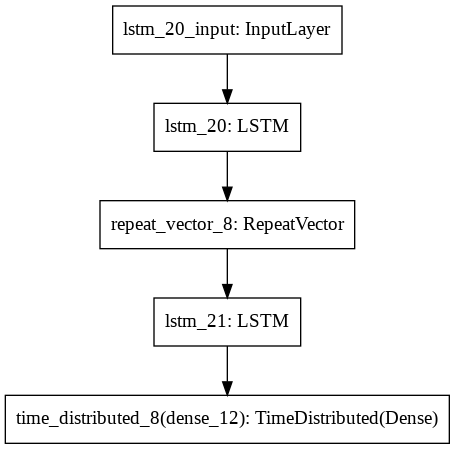

In [92]:
neurons=50 #########################################################test with grid search
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False),
  tf.keras.layers.RepeatVector(n_out),
  tf.keras.layers.LSTM(neurons,return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=n_out_features, activation='linear'))


])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print(model.summary())

tf.keras.utils.plot_model(model)
#tf.keras.utils.plot_model(model, to_file='lstm-bjpm25-keras_graph.png')

#display(Image.open('lstm-bjpm25-keras_graph.png'))

## **Train model**


In [93]:

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 35040 samples, validate on 8733 samples
Epoch 1/50
35040/35040 - 18s - loss: 0.0135 - mae: 0.0658 - val_loss: 0.0223 - val_mae: 0.0983
Epoch 2/50
35040/35040 - 13s - loss: 0.0036 - mae: 0.0375 - val_loss: 0.0168 - val_mae: 0.0831
Epoch 3/50
35040/35040 - 13s - loss: 0.0029 - mae: 0.0344 - val_loss: 0.0135 - val_mae: 0.0760
Epoch 4/50
35040/35040 - 12s - loss: 0.0025 - mae: 0.0320 - val_loss: 0.0107 - val_mae: 0.0682
Epoch 5/50
35040/35040 - 12s - loss: 0.0023 - mae: 0.0306 - val_loss: 0.0080 - val_mae: 0.0596
Epoch 6/50
35040/35040 - 13s - loss: 0.0023 - mae: 0.0297 - val_loss: 0.0063 - val_mae: 0.0532
Epoch 7/50
35040/35040 - 12s - loss: 0.0021 - mae: 0.0283 - val_loss: 0.0046 - val_mae: 0.0459
Epoch 8/50
35040/35040 - 12s - loss: 0.0018 - mae: 0.0262 - val_loss: 0.0035 - val_mae: 0.0400
Epoch 9/50
35040/35040 - 12s - loss: 0.0015 - mae: 0.0236 - val_loss: 0.0026 - val_mae: 0.0333
Epoch 10/50
35040/35040 - 13s - loss: 0.0013 - mae: 0.0216 - val_loss: 0.0021 - val_mae: 0.0292


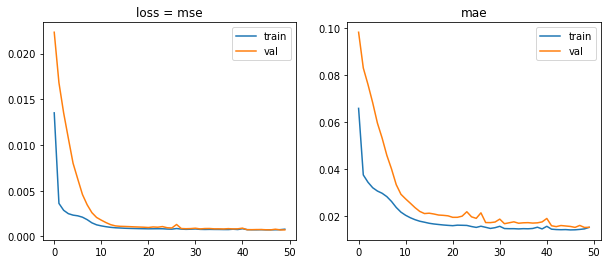

In [94]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss = mse')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.title('mae')
plt.legend()
plt.show() 

## **Prediction**

In [95]:
# make a prediction
yhat = model.predict(test_X)
yhat.shape

(8733, 4, 4)

In [0]:
yhat = yhat.reshape((len(yhat), n_out*n_out_features))
inv_yhat = np.round(scaler_out.inverse_transform(yhat).reshape((len(yhat), n_out,n_out_features)))

test_y=test_y.reshape((len(test_y), n_out*n_out_features))
inv_y = np.round(scaler_out.inverse_transform(test_y).reshape((len(test_y), n_out,n_out_features)))

In [97]:
# calculate RMSE
for i in range(n_out_features):
  print('forecast of %s' %(out_features[i]))
  for ts in range(n_out):
    rmse = np.sqrt(mean_squared_error(inv_y[:,ts,i], inv_yhat[:,ts,i]))
    mean = np.mean(inv_y[:,ts,i])
    print('timestep: %d, mean=%.2f, rmse=%.2f' % (ts,mean, rmse))

forecast of pm2.5
timestep: 0, mean=96.78, rmse=26.48
timestep: 1, mean=96.76, rmse=35.80
timestep: 2, mean=96.74, rmse=42.75
timestep: 3, mean=96.73, rmse=48.21
forecast of temp
timestep: 0, mean=13.70, rmse=1.42
timestep: 1, mean=13.70, rmse=1.72
timestep: 2, mean=13.70, rmse=1.94
timestep: 3, mean=13.70, rmse=2.13
forecast of rain
timestep: 0, mean=0.14, rmse=0.52
timestep: 1, mean=0.14, rmse=0.67
timestep: 2, mean=0.14, rmse=0.76
timestep: 3, mean=0.14, rmse=0.83
forecast of hour
timestep: 0, mean=11.50, rmse=0.13
timestep: 1, mean=11.50, rmse=0.10
timestep: 2, mean=11.50, rmse=0.12
timestep: 3, mean=11.50, rmse=0.09


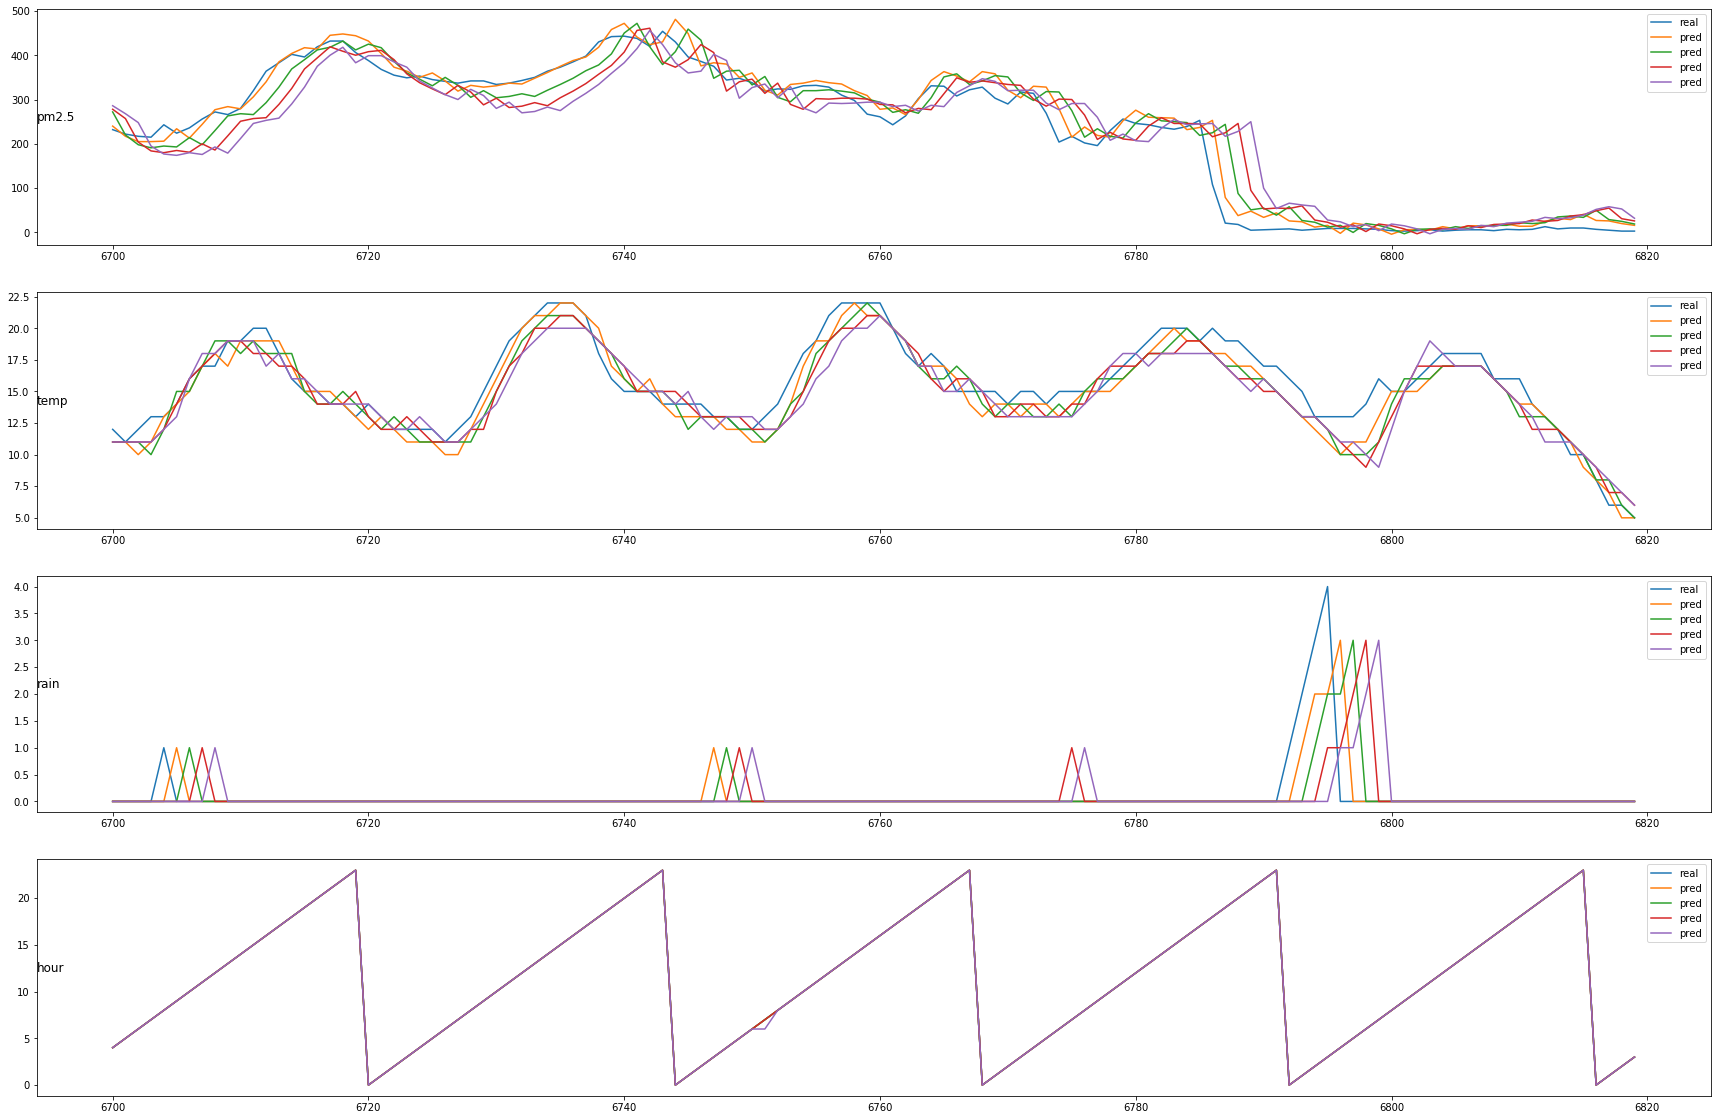

In [98]:
disp1=6700
disp2=6820
x = np.arange(disp1,disp2)
plt.figure(figsize=(30,20))
for i in range(n_out_features): 
  plt.subplot(n_out_features ,1,i+1)
  plt.plot(x,inv_y[disp1:disp2,0,i], label='real')
  for ts in range(n_out) :
    plt.plot(x,inv_yhat[disp1-ts:disp2-ts,ts,i], label='pred')
    plt.legend()
    plt.title(out_features[i], y=0.5, loc='left')

plt.show() 

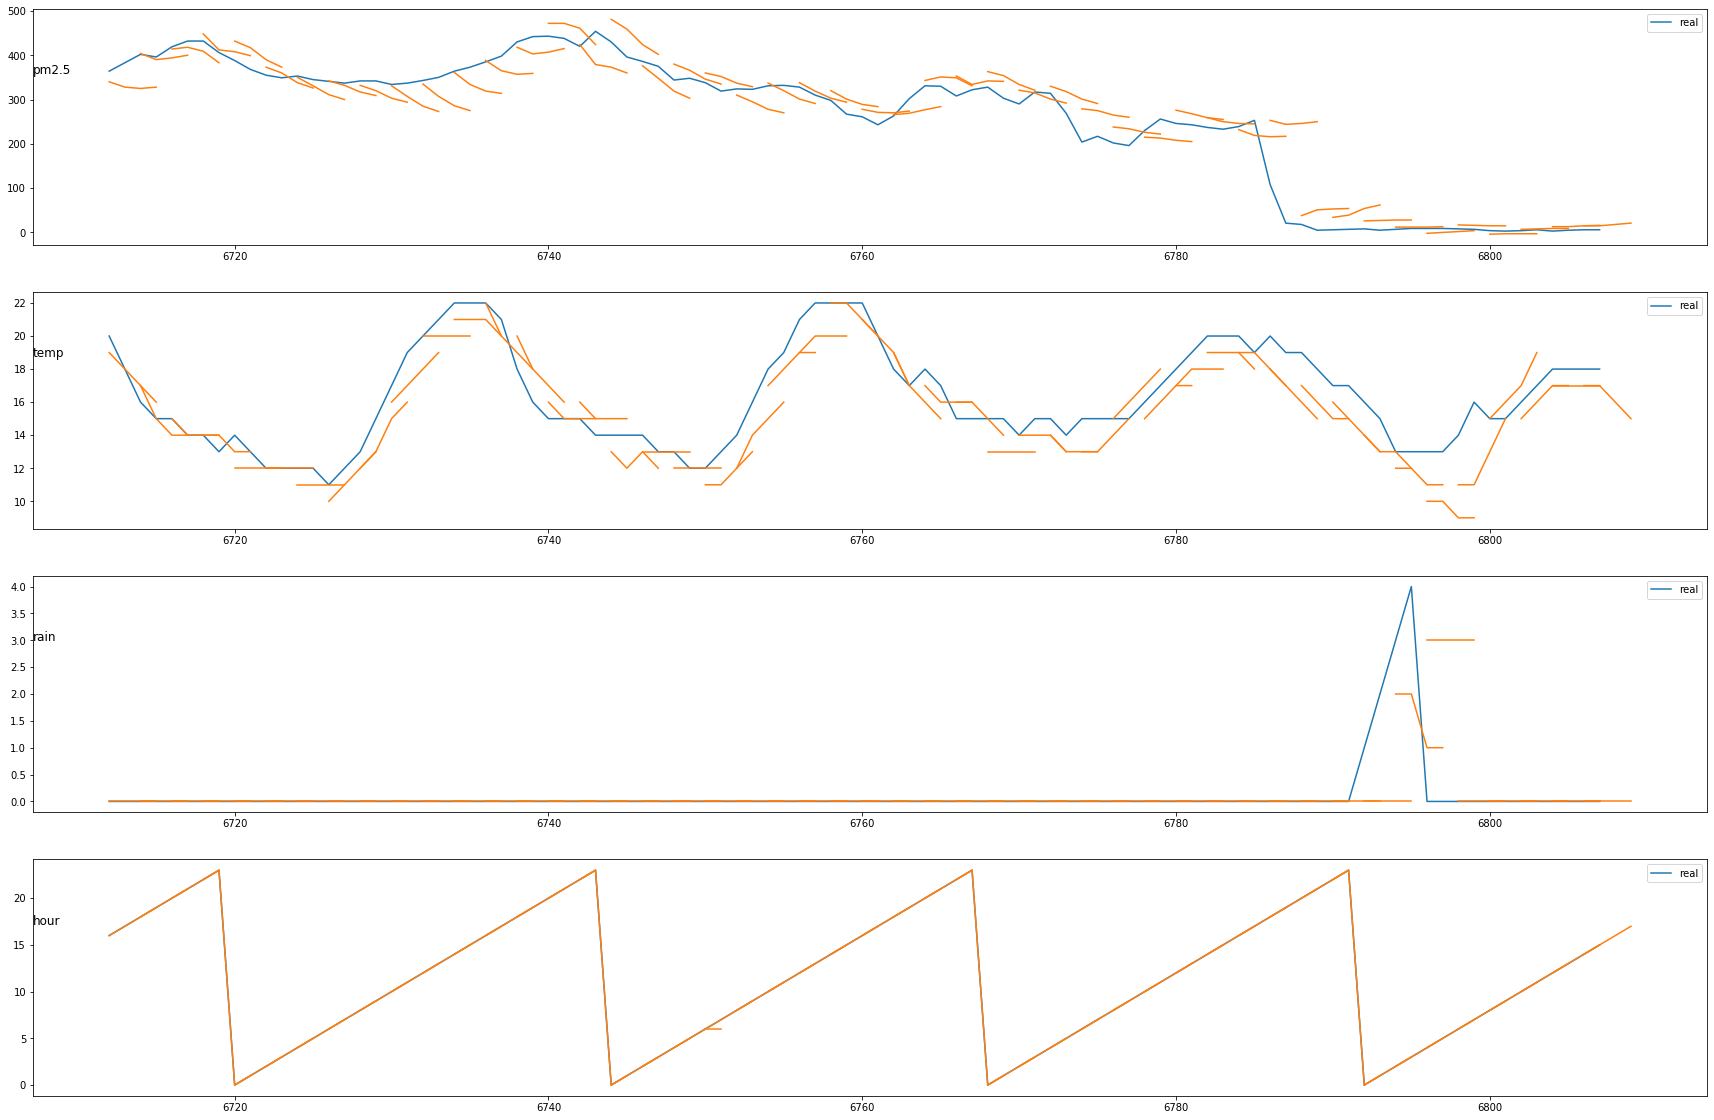

In [99]:
disp1=6712
disp2=6808
x = np.arange(disp1,disp2)
intv = 2
plt.figure(figsize=(30,20))
for i in range(n_out_features): 
  plt.subplot(n_out_features ,1,i+1)
  plt.plot(x,inv_y[disp1:disp2,0,i], label='real')
  plt.legend()
  for disp in range(disp1,disp2,intv) :
    plt.plot(x[0:n_out]+(disp-disp1),inv_yhat[disp,0:n_out,i], color='C1', label='pred')
    plt.title(out_features[i], y=0.7, loc='left')
  
plt.show() 

## Output

In [0]:
#output.to_csv('time-series-bjpm25-lstm-v2.csv', index = False)


In [0]:
#model.save("time-series-bjpm25-lstm-v2.h5")

## **Remarks**

tests show that pm2.5 rmse is not sensitive to neuron number in the range of 40-100, lag hours 12-48

other 3 features also are not sensitive to neuron number 40-100, but improves as lag hours increase from 12-48

outputing pm2.5 with other features doesn't afffect the result.


## **Future works**

*   use keras function api
*   experiment different features
*   Making all series stationary with differencing and seasonal adjustment. https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

*   internal state depends on number of days





# **Credit**

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/

